# Data Scrapping form the European Medicines Agency (EMA)
## *Miquel Anglada Girotto*

In this notebook, I exemplify how the European Medicines Agency (EMA) web page can be scrapped to retrieve information from 1995 to 2018. Then, I performed exploratory data analysis on the downloaded dataset to carry out a personal analysis of pharmaceutical development in Europe.

## Load required dependencies

In [132]:
# libraries
library(RSelenium)
library(stringr)

# self-made package
source("EMA_webScrapping.R")

## Set parameters

In [ ]:
# start automated navigator
initRSelenium()

# Navigate to a list of all drugs
url = "https://www.ema.europa.eu/medicines/field_ema_web_categories%253Aname_field/Human/ema_group_types/ema_medicine"
remDr$navigate(url)

# Define pages to look through
page <- "https://www.ema.europa.eu/en/medicines/field_ema_web_categories%253Aname_field/Human/ema_group_types/ema_medicine?page=" #link to navigate through each page of the list.
n <- as.character(round(1495/25)-1) #no. of pages to navigate, as.character() to allow pasting with the 'page' string.

## Download information from each drug

In [ ]:
# Obtain each drug's link
drug_links = getURLs(page,n)

# Use drug links to retrieve information from EMA's webpage for each drug
# (Slow)
drugsDB = getDrugInfo(drug_links)

## Save information in spreadsheet

In [ ]:
# reshape dataframe and fill when features available
drug_df = processTable(drugsDB)

# save
file_name = "drug_df_EMA.csv"
#saveTable(drug_df,file_name)

# Exploratory Data Analysis

The "scrapped dataset" contains 1272 columns and 20 fields that describe each of the drugs registered in the EMA, approved or rejected.

To further study available data I subsetted `drug_df` into `df` with fewer columns and easy-to-work-with names.

In [27]:
# load
drug_df = read.table('drug_df_EMA.csv',sep=',',header=T,stringsAsFactors = F)

In [28]:
# Number of registered drugs
paste('Total EMA registered drugs:',nrow(drug_df))

# Fields names
"Table fields:"
print(colnames(drug_df))

[1] "Total EMA registered drugs: 1272"

[1] "Table fields:"

 [1] "Name"                                                                        
 [2] "Agency.product.number"                                                       
 [3] "Active.substance"                                                            
 [4] "International.non.proprietary.name..INN..or.common.name"                     
 [5] "Therapeutic.area..MeSH."                                                     
 [6] "Anatomical.therapeutic.chemical..ATC..code"                                  
 [7] "Generic"                                                                     
 [8] "Marketing.authorisation.holder"                                              
 [9] "Revision"                                                                    
[10] "Date.of.issue.of.marketing.authorisation.valid.throughout.the.European.Union"
[11] "Contact.address"                                                             
[12] "Additional.monitoring"                                                

In [29]:
# make new df with features of interest
df = drug_df['Name']

df['substance_act'] = drug_df['Active.substance']

df['substance_inn'] = drug_df['International.non.proprietary.name..INN..or.common.name']

df['Generic'] = drug_df['Generic']!=''

df['Orphan'] = drug_df['Orphan']!=''

df[['Dates']] = strptime(drug_df[['Date.of.issue.of.marketing.authorisation.valid.throughout.the.European.Union']], "%d/%m/%Y")
df['Years'] = format(df['Dates'], "%Y")

df['ex_circ'] = drug_df['Exceptional.circumstances']!=''

df['Countries'] = drug_df['Countries']

df['mah'] = drug_df['Marketing.authorisation.holder']

df['mesh'] = drug_df['Therapeutic.area..MeSH.']

# Data cleaning and wrangling
#df = df[df$mah != '',]

# check
print(paste('The clean dataframe has ',nrow(df),'entries.'))
head(df)

[1] "The clean dataframe has  1272 entries."


Name,substance_act,substance_inn,Generic,Orphan,Dates,Years,ex_circ,Countries,mah,mesh
<chr>,<chr>,<chr>,"<lgl[,1]>","<lgl[,1]>",<dttm>,<I<chr>>,"<lgl[,1]>",<chr>,<chr>,<chr>
Bortezomib Sun,bortezomib,bortezomib,TRUE,FALSE,2016-07-22,2016,FALSE,The Netherlands,SUN Pharmaceutical Industries (Europe) B.V.,Multiple Myeloma
Verzenios,abemaciclib,abemaciclib,FALSE,FALSE,2018-09-26,2018,FALSE,The Netherlands,Eli Lilly Nederland B.V.,Breast Neoplasms
Orgalutran,ganirelix,ganirelix,FALSE,FALSE,2000-05-16,2000,FALSE,The Netherlands,Merck Sharp and Dohme B.V,"Reproductive Techniques, Assisted Ovulation Induction"
Aldurazyme,laronidase,laronidase,FALSE,TRUE,2003-06-09,2003,FALSE,The Netherlands,Genzyme Europe B.V.,Mucopolysaccharidosis I
Imatinib Accord,imatinib,imatinib,TRUE,FALSE,2013-06-30,2013,FALSE,United Kingdom,Accord Healthcare Ltd,"Precursor Cell Lymphoblastic Leukemia-Lymphoma Dermatofibrosarcoma Myelodysplastic-Myeloproliferative Diseases Leukemia, Myelogenous, Chronic, BCR-ABL Positive Hypereosinophilic Syndrome"
Levetiracetam Actavis Group,levetiracetam,levetiracetam,TRUE,FALSE,2011-12-04,2011,FALSE,Iceland,Actavis Group PTC ehf,Epilepsy


## Therapeutic Areas

### Which are the most common therapeutic areas?

To start, we may compute the percentage of appearance of MeSH terms in drug indications to understand which therapeutic areas may hold most interest.

In [84]:
# list drugs and their therapeutic area MeSH

# split mesh terms
list_mesh <- lapply(df$mesh,split="\n",strsplit)

# add drug names
attributes(list_mesh)$names <- drug_df$Name

# compute total diversity
paste('Diversity in therapeutic areas:',length(unique(list_mesh)))

# compute frequency table of MeSH terms
tab_mesh = table(unlist(list_mesh))
tab_mesh = tab_mesh/length(tab_mesh)
tab_mesh = sort(tab_mesh,decreasing = T)

'Top 10:'
sort(tab_mesh,decreasing = T)[1:10]

'Last 10:'
sort(tab_mesh,decreasing = F)[1:10]

[1] "Diversity in therapeutic areas: 509"

[1] "Top 10:"


     Diabetes Mellitus, Type 2                 HIV Infections 
                    0.15839243                     0.14420804 
                  Immunization                   Hypertension 
                    0.12056738                     0.10401891 
              Breast Neoplasms          Myocardial Infarction 
                    0.09929078                     0.09456265 
Carcinoma, Non-Small-Cell Lung          Arthritis, Rheumatoid 
                    0.09219858                     0.08510638 
                        Cancer              Diabetes Mellitus 
                    0.08274232                     0.06855792 

[1] "Last 10:"


                Acromegaly                    Adenoma 
               0.002364066                0.002364066 
Adenomatous Polyposis Coli   Adrenal Cortex Neoplasms 
               0.002364066                0.002364066 
     Adrenal Insufficiency  Alcohol-Related Disorders 
               0.002364066                0.002364066 
        alpha-Mannosidosis      Amyloidosis, Familial 
               0.002364066                0.002364066 
   Anemia, Iron-Deficiency        Anemia, Sickle Cell 
               0.002364066                0.002364066 

Most of the drugs developed target chronic diseases like diabetes, cancer, HIV or heart complications. The inability to find a cure to this diseases may explain why most of the companies decided to tackle them. However, data may also indicate, as spread throughout public opinion, that pharmaceutical investments could be biased towards chronic diseases because they guarantee a constant revenue.

On the other side of the list, we find genetic and rare diseases (e.g. sickle cell anemia, acromegaly) that would require complex therapies.

### Approval evolution in therapeutic areas

Drug development in certain areas may have had different evolution in the EMA. Below, I plotted the evolution of the number of approved drugs for each MeSH area.

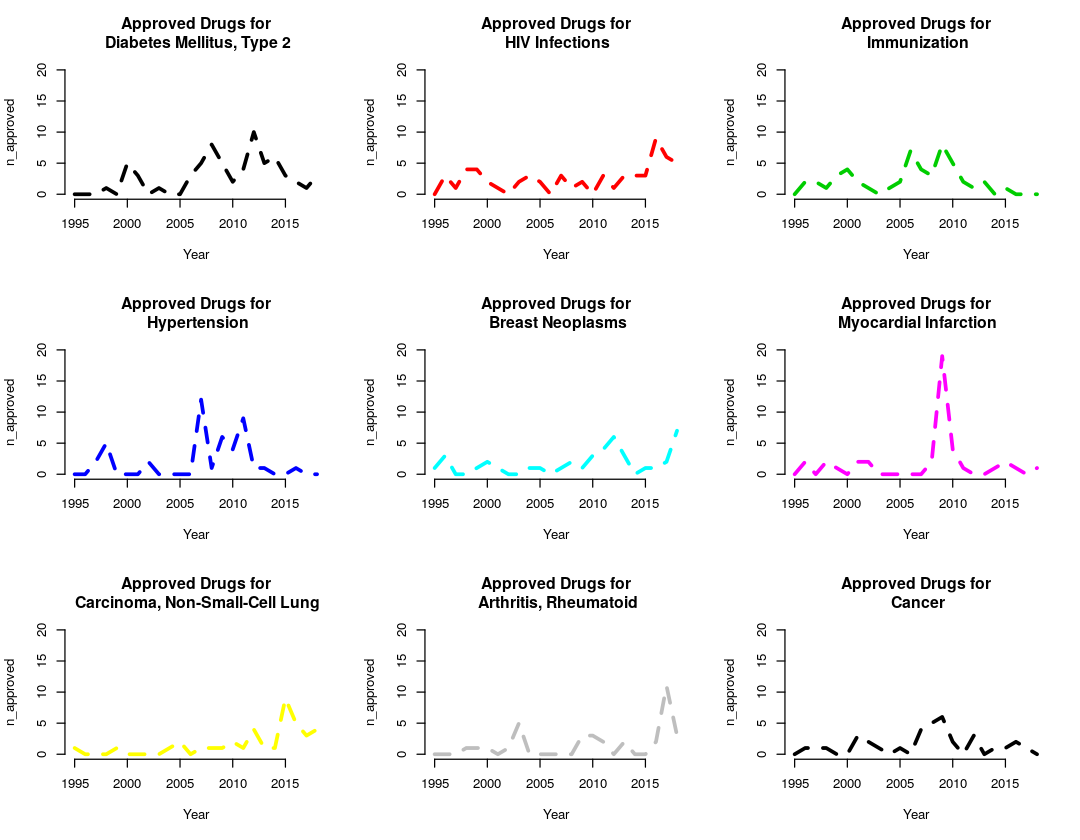

In [89]:
# number of drugs per area per year
n_areas = 10
years = 1995:2018
area_year = matrix(nrow=n_areas,ncol=length(years))
rownames(area_year) = names(tab_mesh)[1:n_areas]
colnames(area_year) = years

for (area in names(tab_mesh)[1:n_areas]){
    # find drug names that contain a certain "area"
    idx_area = sapply(list_mesh,function(x){any(unlist(x) %in% area)})
    # get year of each drug of the area
    tmp_years = df[idx_area,'Years']
    tmp_years = table(tmp_years[!is.na(tmp_years)])
    # save
    area_year[area, colnames(area_year) %in% names(tmp_years)] = tmp_years
}
area_year[is.na(area_year)] = 0

# visualize
options(repr.plot.width=9, repr.plot.height=7)

par(mfrow=c(3,3))
for (i in 1:length(tmp[1:n_countries])){
    plot(as.numeric(colnames(area_year)),area_year[i,],main=paste('Approved Drugs for\n',rownames(area_year)[i]),type='l',bty='n',xlab='Year',ylab='n_approved',col=i,lty=2,lwd=3,ylim=c(0,20))
}

In most of the cases, the number of drugs approved every year is steady or increases towards the end probably thanks to new research insights.

Interestingly, drugs for treating heart-related diseases (hypertension, myocardial infarction) show a clear peak between 2005 and 2010.
In particular, the peak in myocardial infarction was related to the approval of 28 generic drugs based on the compound *clopidogrel*.

## Generics

Generics are the low-cost versions of drugs that can be marketed when the marketing exclusivity of another drug expires.
They can be sold at lower prices because they only need to perform safety trials.

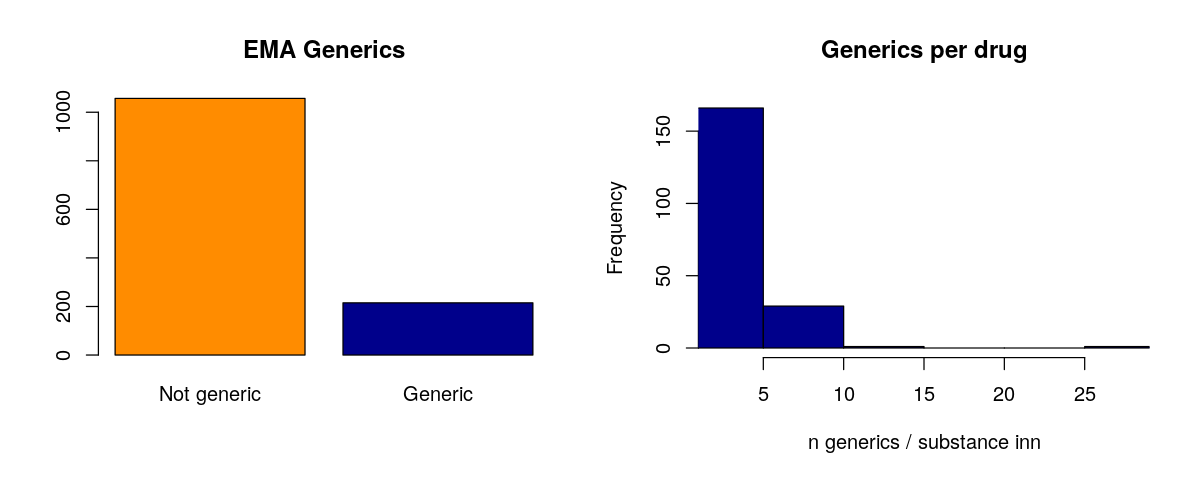

In [134]:
# visualization
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow=c(1,2))

# Proportion of generics
barplot(table(df['Generic']), main = 'EMA Generics',col=c('darkorange','darkblue'),names.arg = c('Not generic','Generic'))
#legend('topright',legend = c('Not generic','Generic'),fill = c('darkorange','darkblue'))

# Generics per drug
tmp = table(df['substance_inn'])
tmp = tmp[tmp!=1]
gen_drug = tmp[order(tmp,decreasing=T)]
hist(gen_drug, main = 'Generics per drug',col='darkblue', xlab='n generics / substance inn', xlim=c(2,max(gen_drug)))

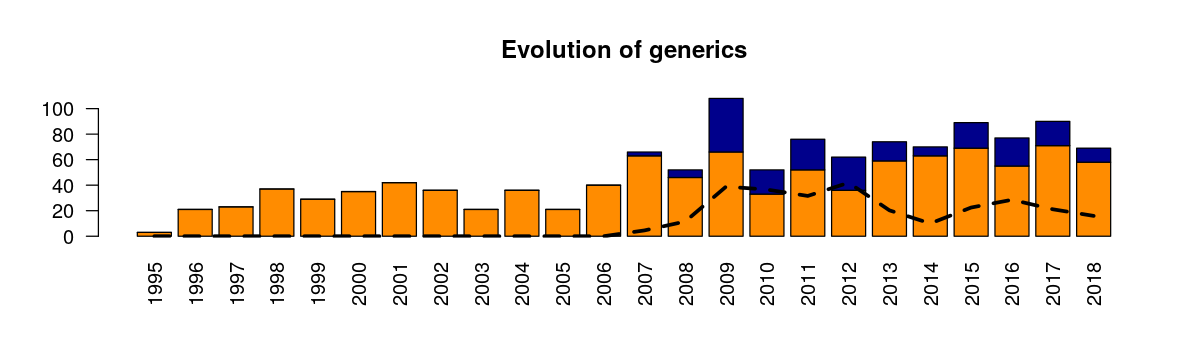

In [32]:
# visualization options
options(repr.plot.width=10, repr.plot.height=3)

# Evolution of generics
tmp = table(df$Generic,df$Years)
df.bar = barplot(tmp,col=c('darkorange','darkblue'),las=2, main='Evolution of generics')
lines(df.bar,(tmp[2,]/colSums(tmp))*100,lty=2,lwd=3)

Generic drugs start appearing slowly after the approval of the equivalent non-generic drug. Surprisingly, there can be more than one generic per drug.

As mentioned below, *clopidogrel* is the compound with more generics and had been object of patent infringement litigation ([ref](https://www.ft.com/content/20159dfe-2e50-11db-93ad-0000779e2340)).

In [90]:
# which one is the maximum?
name_max = names(gen_drug)[1]
print(paste(name_max,'is the drug with more generic versions,',gen_drug[1],'in particular.'))

# which are its indications
# get Name of non generic versions
selected_drug_names = df[(df['substance_inn'] == name_max) & (df['Generic'] == F), 'Name']
selected_indications = unique(unlist(list_mesh[selected_drug_names]))

print(paste(name_max, 'is indicated for',selected_indications))

[1] "clopidogrel is the drug with more generic versions, 28 in particular."
[1] "clopidogrel is indicated for Stroke"                      
[2] "clopidogrel is indicated for Peripheral Vascular Diseases"
[3] "clopidogrel is indicated for Myocardial Infarction"       
[4] "clopidogrel is indicated for Acute Coronary Syndrome"     
[5] "clopidogrel is indicated for Atrial Fibrillation"         


In [34]:
# How much later were generics approved?
df[df['substance_inn'] == 'clopidogrel',]

,Name,substance_act,substance_inn,Generic,Orphan,Dates,Years,ex_circ,Countries,mah,mesh
,<chr>,<chr>,<chr>,"<lgl[,1]>","<lgl[,1]>",<dttm>,<I<chr>>,"<lgl[,1]>",<chr>,<chr>,<chr>
124,Clopidogrel Apotex (previously Clopidogrel Mylan Pharma),clopidogrel besilate,clopidogrel,TRUE,FALSE,2009-10-15,2009,FALSE,The Netherlands,Apotex Europe B.V.,Peripheral Vascular Diseases Stroke Myocardial Infarction
390,Clopidogrel HCS,clopidogrel hydrochloride,clopidogrel,TRUE,FALSE,2010-10-27,2010,FALSE,Belgium,HCS bvba,Peripheral Vascular Diseases Acute Coronary Syndrome Myocardial Infarction Stroke
517,Grepid,clopidogrel besilate,clopidogrel,TRUE,FALSE,2009-07-27,2009,FALSE,Greece,Pharmathen S.A.,Peripheral Vascular Diseases Stroke Myocardial Infarction
543,Clopidogrel Zentiva (previously Clopidogrel Winthrop),clopidogrel,clopidogrel,FALSE,FALSE,2008-07-15,2008,FALSE,Czech Republic,Zentiva k.s.,Stroke Peripheral Vascular Diseases Myocardial Infarction Acute Coronary Syndrome
580,Clopidogrel Mylan,clopidogrel hydrochloride,clopidogrel,TRUE,FALSE,2009-09-20,2009,FALSE,France,Mylan S.A.S.,Peripheral Vascular Diseases Stroke Myocardial Infarction
582,Clopidogrel Krka,clopidogrel hydrochloride,clopidogrel,TRUE,FALSE,2009-09-22,2009,FALSE,Slovenia,"Krka, d.d., Novo mesto",Peripheral Vascular Diseases Stroke Myocardial Infarction
585,Zyllt,clopidogrel hydrogen sulphate,clopidogrel,TRUE,FALSE,2009-09-28,2009,FALSE,Slovenia,"Krka, d.d., Novo mesto",Peripheral Vascular Diseases Stroke Acute Coronary Syndrome Myocardial Infarction
589,Clopidogrel TAD,clopidogrel hydrochloride,clopidogrel,TRUE,FALSE,2009-09-22,2009,FALSE,Germany,Tad Pharma GmbH,Peripheral Vascular Diseases Stroke Myocardial Infarction
607,Clopidogrel ratiopharm GmbH,clopidogrel,clopidogrel,TRUE,FALSE,2009-07-27,2009,FALSE,Czech Republic,Archie Samiel s.r.o.,Peripheral Vascular Diseases Acute Coronary Syndrome Myocardial Infarction Stroke


## Orphan drugs

From the year 2000, orphan drug development is promoted by the EMA. Indeed, they only appear from the year 2001, after the definition of "orphan designation" by the EMA in 2000 ([see Regulation](https://www.ema.europa.eu/en/human-regulatory/overview/orphan-designation/legal-framework-orphan-designation)).

In relation to the drugs approved last year 2018, the proportion of approved orphan drugs is at the highest levels compared to the past. This may indicate that the directives from the EMA are starting to show a clear effect in research and development of drugs that apparently may not be of direct economic interest. On the other hand, since orphan drugs target rare diseases, the high rate of approval may be confouded by an accelerated approval because potential benefits outperform risks.

[1] "12.66 % of the drugs registered are orphan."


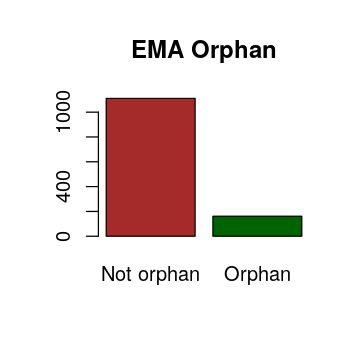

In [133]:
# visualize
options(repr.plot.width=3, repr.plot.height=3)

# Orphan vs non-orphan
tmp = table(df$Orphan)
barplot(tmp, main = 'EMA Orphan',col=c('brown','darkgreen'),names.arg = c('Not orphan','Orphan'))
#legend('topright',legend = c('Not orphan','Orphan'),fill = c('brown','darkgreen'))

print(paste(round(100*tmp[2]/sum(tmp),2),'% of the drugs registered are orphan.'))

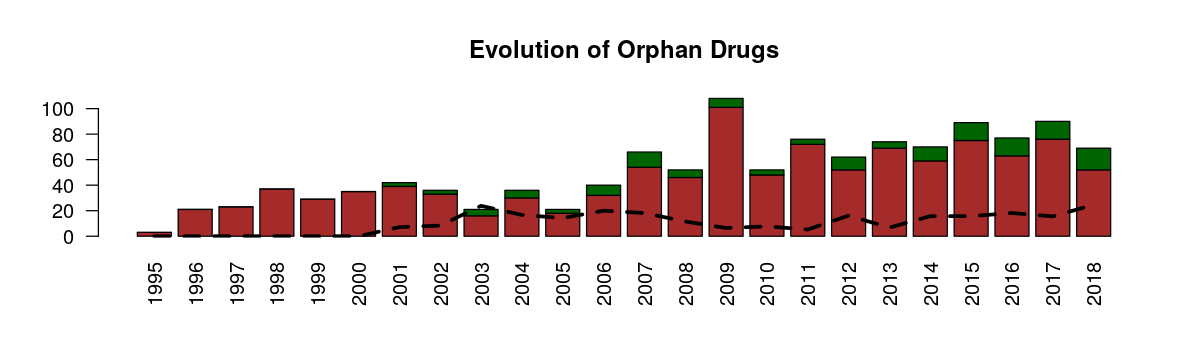

In [36]:
# visualization options
options(repr.plot.width=10, repr.plot.height=3)

# Evolution of orphan drugs
tmp = table(df$Orphan,df$Years)
df.bar = barplot(tmp,col=c('brown','darkgreen'),las=2, main='Evolution of Orphan Drugs')
lines(df.bar,(tmp[2,]/colSums(tmp))*100,lty=2,lwd=3)

## Countries

Below I analyzed which countries hold the Marketing Authorizations of approved drugs.

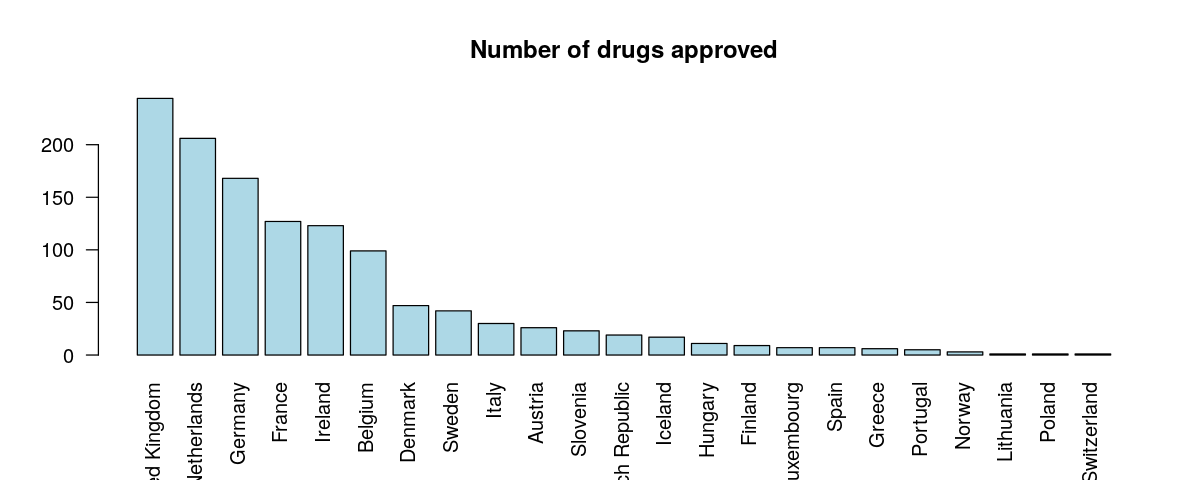

In [37]:
# visualize
options(repr.plot.width=10, repr.plot.height=4)

# Orphan vs non-orphan
tmp = table(df$Countries[df$Countries!='']) # unsuccessful applications will have an empty Country

tmp = tmp[order(tmp, decreasing = T)]
barplot(tmp, main = 'Number of drugs approved',las=2,col='lightblue')

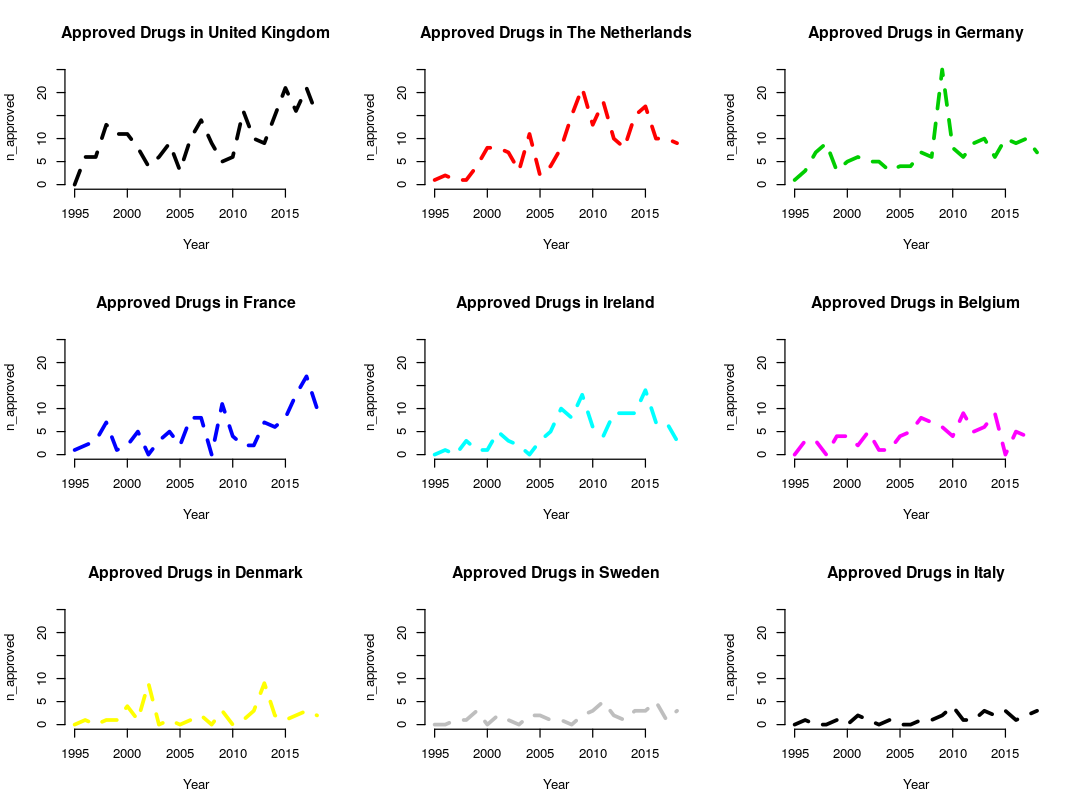

In [38]:
# visualize
n_countries = 9
options(repr.plot.width=9, repr.plot.height=n_countries*0.75)

# Evolution
tmp = table(df$Countries,df$Years)
tmp = tmp[order(rowSums(tmp),decreasing=T),]

par(mfrow=c(n_countries%/%3,3))
for (i in 1:length(tmp[1:n_countries])){
    plot(as.numeric(colnames(tmp)),tmp[i,],main=paste('Approved Drugs in',rownames(tmp)[i]),type='l',bty='n',xlab='Year',ylab='n_approved',col=i,lty=2,lwd=3,ylim=c(0,25))
}

The general trends for countries with more than 100 approved drugs are show trends linearly positive indicating that either countries "improve" in how to get drugs approved or that companies strategically choose countries closer to the EMA headquarters (London, UK) to facilitate administrative interactions. In the case of Germany, the peak corresponds to the approval of many generics of the *clopidogrel*.

## Companies holding Marketing Authorisations

In this section I dissect EMA public data to understand the main trends among european companies to approve their products.

In [39]:
# MAH top ten
tmp = table(df$mah[df$mah!=''])# unsuccessful applications will have an empty mah
order_freq = order(tmp, decreasing = T)
tmp = tmp[order_freq]

print(paste('There are a total of',length(tmp),'different companies registered as MAH.'))
print('These are the top 10:')
print(tmp[1:10])

mah_freq = tmp

[1] "There are a total of 448 different companies registered as MAH."
[1] "These are the top 10:"

             Novartis Europharm Limited                               Teva B.V. 
                                     54                                      28 
               Eli Lilly Nederland B.V.                   Pfizer Europe MA EEIG 
                                     25                                      25 
               Merck Sharp & Dohme B.V.                        Novo Nordisk A/S 
                                     22                                      22 
                         AstraZeneca AB Boehringer Ingelheim International GmbH 
                                     21                                      21 
                Roche Registration GmbH                          Pfizer Limited 
                                     21                                      18 


### Disease interests of each company

Pharmaceutical companies main revenues are based on the number on prescriptions. Then, a pharmaceutical company may opt to either develop a drug product with a broad range of indications (many patients) or the best drug(s) for a small number of indications. 

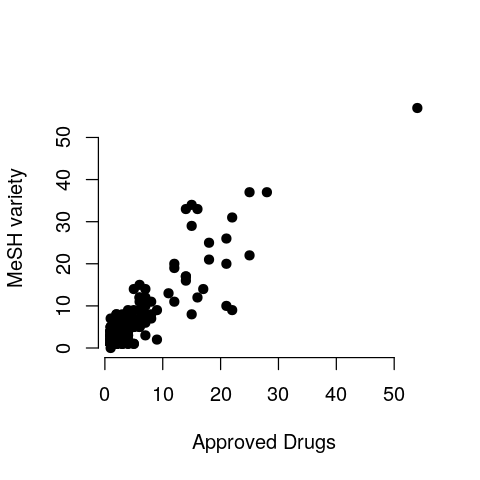

In [102]:
disint = list() # init disease interests
for (tmp_mah in names(mah_freq)){
    # subset
    idx_names = df[df['mah'] == tmp_mah,1] # 1st column is the Names column
    
    # get mesh vocabulary for tmp_mah
    disint[tmp_mah] = list(unique(unlist(list_mesh[idx_names])))
}

#print('Number of different indications for the top 10 most MAHs:')
tmp = sapply(disint,length)
#print(tmp[1:10])
mah_disint = tmp

tmp = tmp[order(tmp,decreasing=T)]
#print('')
#print('Top 10 companies with most different indications among their products:')
#print(tmp[1:10])

options(repr.plot.width=4, repr.plot.height=4)
plot(as.vector(mah_freq),as.vector(mah_disint),pch=19,bty='n',xlab='Approved Drugs',ylab='MeSH variety')

The number of approved drugs and different indications correlates linearly; most of the companies chose to develop many drugs with few indications, which is more realistic.

### Company level of disease Specificity

Computing the ratio of indications per product we summarize the two variables above into a variable that shows how specific are the products developed by each company in average.

$$Spec_{company} = log_{10}(\frac{n_{Disease Indications}}{n_{Approved Drugs}})$$

In [105]:
tmp = log10(mah_disint / mah_freq)
mah_ratio = tmp

print('Number of indications per product:')
print(tmp[1:10])
print('')

print('Companies that develop products targeting a broad spectrum of indications (Top 10):')
tmp=tmp[order(tmp,decreasing=T)]
print(tmp[1:10])
print('')

print('Companies that develop drugs mostly for the same indications (Top 10):')
tmp=tmp[order(tmp,decreasing=F)]
print(tmp[1:10])

[1] "Number of indications per product:"

             Novartis Europharm Limited                               Teva B.V. 
                             0.02348110                              0.12104369 
               Eli Lilly Nederland B.V.                   Pfizer Europe MA EEIG 
                            -0.05551733                              0.17026172 
               Merck Sharp & Dohme B.V.                        Novo Nordisk A/S 
                             0.14893901                             -0.38818017 
                         AstraZeneca AB Boehringer Ingelheim International GmbH 
                            -0.32221929                             -0.02118930 
                Roche Registration GmbH                          Pfizer Limited 
                             0.09275405                              0.14266750 
[1] ""
[1] "Companies that develop products targeting a broad spectrum of indications (Top 10):"

                   Sanofi Pasteur            Insti

## Which approach was more successful at long term?

I computed a *score* that approximates the *development rate* of a company based on the spread (std) of the data and the total number of approved drugs.

$$ Score_{company} = Std \cdot n_{Approved Drugs} $$

In [116]:
df_mah = data.frame(as.vector(mah_freq),as.vector(mah_disint),as.vector(mah_ratio))
colnames(df_mah) = c('freq','disint','spec')
rownames(df_mah) = names(mah_freq)

# compute the spread of the points along time
tmp = table(df$mah[df$mah!=''],df$Years[df$mah!=''])
tmp = tmp[order_freq,]

df_mah['spread'] = apply(tmp,1,function(row){
    idx_first_mah = which.min(row>0)
    subst = row[idx_first_mah:length(row)]
    return(sd(subst))
})
df_mah['score'] = df_mah$spread*df_mah$freq

df_mah = df_mah[order(df_mah['score'],decreasing=T),]

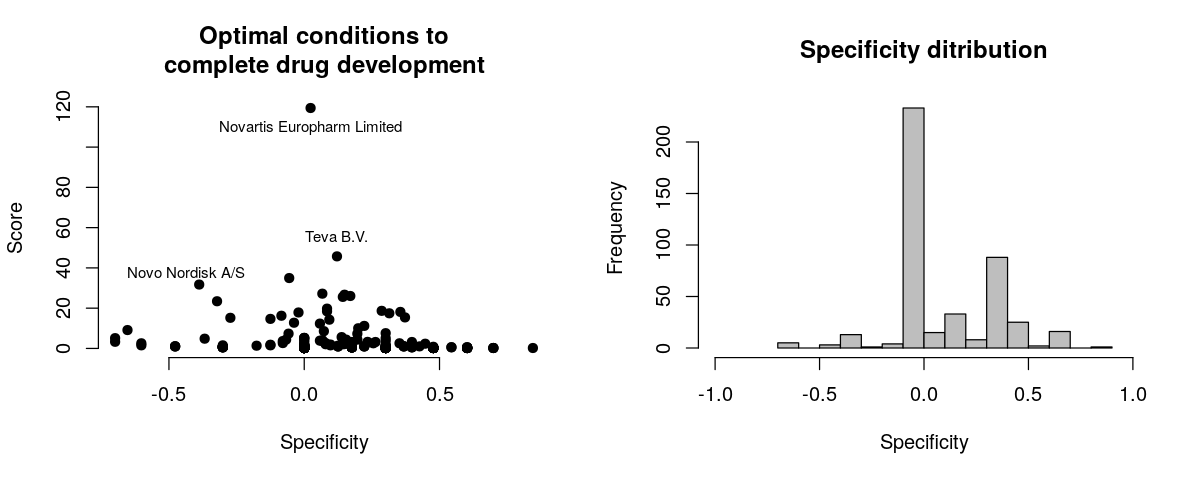

In [132]:
# visualize options
options(repr.plot.width=10, repr.plot.height=4)

# Specificity vs score
par(mfrow=c(1,2))
plot(df_mah$spec,df_mah$score,pch=19,bty='n',xlab='Specificity',ylab='Score',main='Optimal conditions to\ncomplete drug development')
text(df_mah$spec[1],df_mah$score[1]-10,rownames(df_mah)[1],cex=.75)
text(df_mah$spec[2],df_mah$score[2]+10,rownames(df_mah)[2],cex=.75)
text(df_mah$spec[4]-0.05,df_mah$score[4]+6,rownames(df_mah)[4],cex=.75)

hist(df_mah$spec,main='Specificity ditribution',breaks=12,col='grey',xlab='Specificity',xlim=c(-1,1))

Apparently, there is a tradeoff in drug development between constant development of many and very specific products and development of few products targeting many indications. There are no cases of companies constantly developing products that cover a broad range of indications. Developing many specific products ensures a constant rate of MA approvals and revenue (e.g. Novartis Europharm Limited and Teva B.V.). Nevertheless, we see certain companies like Novo Nordisk A/S that developed many products covering a the same indications. This strategy may respond to the rationale of modifying the same drug to re-approve it with the need of less clinical trials, with the high risk that this implies.

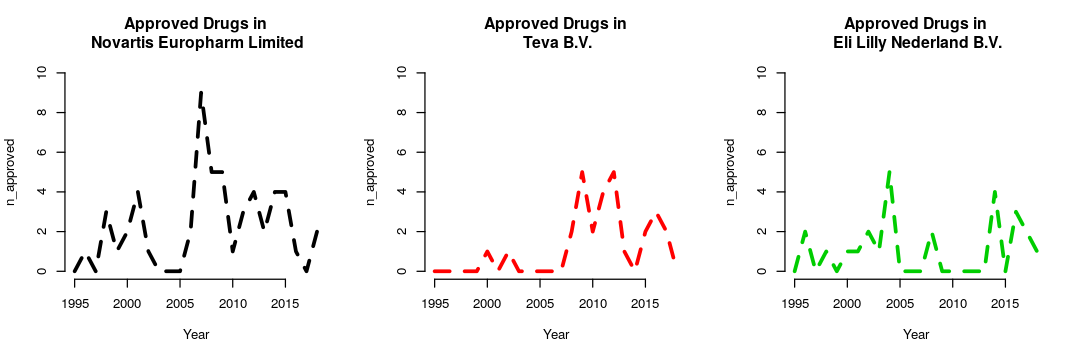

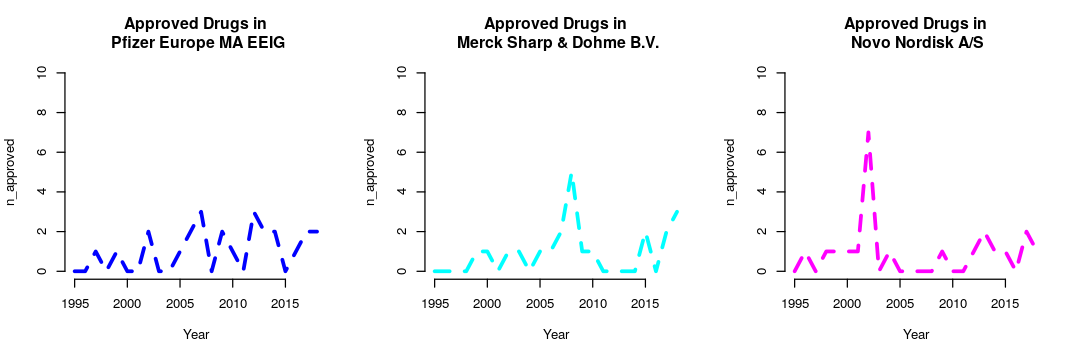

In [125]:
# visualize
options(repr.plot.width=9, repr.plot.height=3)

# Evolution
par(mfrow=c(1,3))
for (i in 1:6 ){
    plot(as.numeric(colnames(tmp)),tmp[i,],main=paste('Approved Drugs in\n',rownames(tmp)[i]),type='l',bty='n',xlab='Year',ylab='n_approved',col=i,lty=2,lwd=3,ylim=c(0,10))
}

According to EMA public data, in the last 28 years companies pushed forward the development of new drugs that may be indicated for a broad number of diseases or developing drugs for different treatment areas were the approaches chosen by companies with most approved drugs.

Nevertheless, it seems that a large number of companies are developing drugs targeting a broad spectrum of indications; they do not need to approve more drugs because they will receive a constant revenue flow since their market share penetration is deeper.